# Predicting MNIST Handwritten Digits with a CNN

This Jupyter Notebook presents a project focused on using a Convolutional Neural Network (CNN) to classify handwritten digits from the MNIST dataset. The MNIST dataset is a collection of 28x28 pixel grayscale images of handwritten digits, widely used for training and testing in the field of machine learning.


### Project Overview

- **Objective**: To build and train a CNN model to accurately predict the digits represented in the MNIST images.
- **Methods**: Utilization of TensorFlow and Keras libraries for model construction, training, and evaluation.
- **Results**: Analysis of the model's performance using accuracy metrics and a confusion matrix.
- **Conclusion**: Summary of the model's effectiveness and potential improvements.

Clement Hironimus

### Load Libraries & Data

In [134]:
# Load Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from datetime import timedelta

In [85]:
# Load Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

Let's check the shape of the dataset to ensure that we have the expected structure for training and testing.

In [86]:
# Confirming data shape
print(f'''
    X_train shape: {X_train.shape}
    X_test shape: {X_test.shape}
    y_train shape: {y_train.shape}
    y_test shape: {y_test.shape}
''')


    X_train shape: (60000, 28, 28)
    X_test shape: (10000, 28, 28)
    y_train shape: (60000,)
    y_test shape: (10000,)


### Below is a helper function to plot a grid of images along with their true labels and, optionally, predicted labels if provided.

In [87]:
def plot_images(images, y_true, y_pred=None):
    """
    Helper function to plot images with their labels.
    
    Parameters:
    - images: array-like, shape (n_images, img_height, img_width), the images to be plotted.
    - y_true: array-like, shape (n_images,), the true labels of the images.
    - y_pred: array-like, shape (n_images,), the predicted labels of the images (optional).
    """
    # Determine the number of rows needed for the subplots based on the number of images
    n_images = len(images)
    n_cols = 4  # To create 4 columns in the subplot
    n_rows = n_images // n_cols + (n_images % n_cols > 0)  # Calculate rows needed, the "( ... )" is to check if there's a remainder, 1 is added to the number of rows calculated by integer division, otherwise, it adds 0.

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 3 * n_rows)) # 2 inches for each col and row
    axes = axes.flatten()  # Flatten the array of axes for easy iteration
    
    # Loop through all axes and plot each image
    for i, ax in enumerate(axes):
        # Only plot images if the current index is less than the number of images
        if i < n_images:
            ax.imshow(images[i], cmap='binary')  # Show the image in grayscale
            ax.set_title(f"True: {y_true[i]}")  # Set the title to the true label
            if y_pred is not None:  # If predicted labels are provided
                ax.set_xlabel(f"Predicted: {y_pred[i]}")  # Add the predicted label below the image
            ax.set_xticks([])  # Remove x-axis tick marks
            ax.set_yticks([])  # Remove y-axis tick marks
        else:
            ax.axis('off')  # Hide unused subplots if there are any

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the plot


### A helper function to get random indices helps us sample images from the dataset for visualization without bias.

In [88]:
# Helper function to get random sample indices
def get_random_sample_indices(array, sample_count):
    return np.random.choice(
        a=array.shape[0], # Number of rows
        size=sample_count,
        replace=False
    )

### Visualizing a sample of images from the training dataset gives us a glimpse into the variety and types of handwritten digits we're working with.

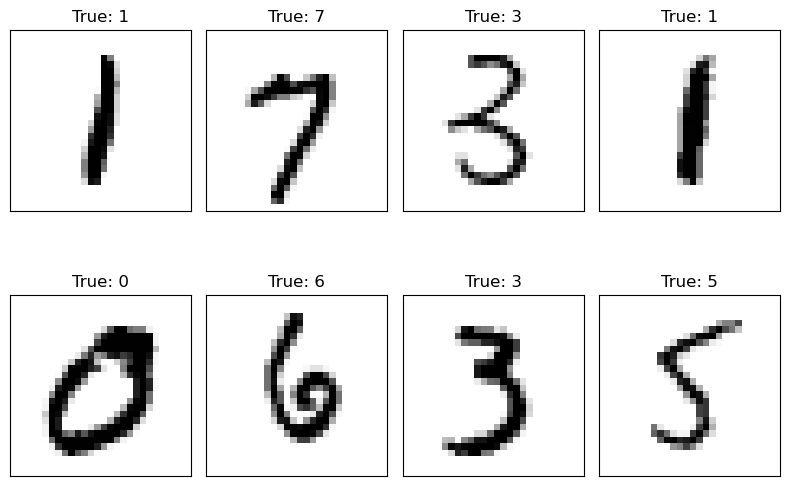

In [89]:
# Get 9 random samples
train_sample_indices = get_random_sample_indices(
    array=X_train,
    sample_count=8
)
plot_images(
    images=X_train[train_sample_indices],
    y_true=y_train[train_sample_indices]
)

### Similarly, let's take a look at a sample from the test dataset to understand the images that the model will be evaluated on.

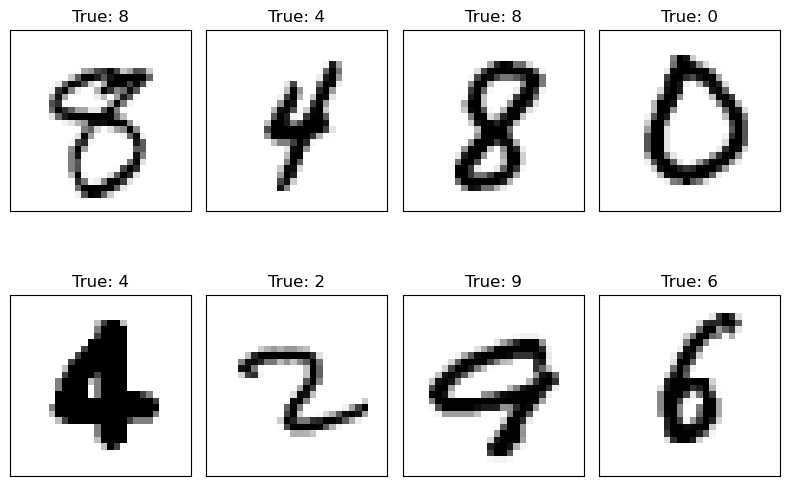

In [90]:
# Get 9 random samples
test_sample_indices = get_random_sample_indices(
    array=X_test,
    sample_count=8
)
plot_images(
    images=X_test[test_sample_indices],
    y_true=y_test[test_sample_indices]
)

### Convolutional Neural Network

The MNIST dataset consists of small, 28x28 pixel, grayscale images of handwritten digits. A CNN is well-suited for this classification task as it can learn to recognize patterns and features in images, such as edges and shapes that compose handwritten digits.


### CNN Architecture

The CNN architecture is designed to progressively learn higher-level features of the images through a series of convolutional and pooling layers, followed by dense layers that perform the classification.

1. **Input Layer**: Accepts the 28x28 pixel images. If the framework requires specifying the number of channels explicitly, it will be 1 (since MNIST images are grayscale).

2. **First Convolutional Layer**: 
   - Filters: 32
   - Kernel size: 3x3 or 5x5
   - Activation function: ReLU (Rectified Linear Unit)
   - This layer is designed to capture low-level features like edges and corners.

3. **First Pooling Layer**: 
   - Type: Max pooling
   - Pool size: 2x2
   - This layer reduces the spatial dimensions (i.e., height and width) of the output from the previous layer, reducing the computation required and helping to extract more significant features.

4. **Second Convolutional Layer**: 
   - Filters: 64
   - Kernel size: 3x3 or 5x5
   - Activation function: ReLU
   - This layer captures more complex features.

5. **Second Pooling Layer**: 
   - Type: Max pooling
   - Pool size: 2x2

6. **Flattening**: The output from the second pooling layer, which is a 3D tensor, needs to be flattened into a 1D vector before being fed into the fully connected layers.

7. **First Fully Connected Layer**: 
   - Neurons: 128 or 256
   - Activation function: ReLU
   - This layer integrates the features learned by the convolutional layers to begin the classification process.

8. **Output Layer**: 
   - Neurons: 10 (since there are 10 digits in MNIST)
   - Activation function: Softmax
   - This layer outputs the probability distribution over the 10 classes (digits).


In [127]:
# Initialize the model
cnn_model = tf.keras.models.Sequential()

# First Convolutional Layer
cnn_model.add(
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        activation='relu',
        input_shape=(28, 28, 1) # The image is 28 row x 28 col x 1 color (greyscale)
    )
)

# First Pooling Layer
cnn_model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2) #The default pool size
    )
)

# Second Convolutional Layer
cnn_model.add(
    tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        activation='relu'
    )
)

# Second Pooling Layer
cnn_model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)
    )
)

# Flatten the result so it can be connected to fully-connected/Dense layers
cnn_model.add(
    tf.keras.layers.Flatten()
)

# First Fully Connected/Dense Layer
cnn_model.add(
    tf.keras.layers.Dense(
        units=128,
        activation='relu'
    )
)

# To prevent overfitting by randomly setting a fraction of the input units to zero at each update during training time
cnn_model.add(tf.keras.layers.Dropout(0.2)) # 35% of neurons output will be randomly set to zero

# Output Layer
cnn_model.add(
    tf.keras.layers.Dense(
        units=10, # Since there are 10 digits
        activation='softmax'
    )
)

cnn_model.compile(
    optimizer='adam',
    metrics='accuracy',
    loss='sparse_categorical_crossentropy',  # Suitable for integer labels (which also reduced the number of columns because we don't do one-hot encoding)
)

## Model Training

Training a neural network involves providing it with training data, in this case, images and their corresponding labels, and allowing it to adjust its weights through a process of optimization. We use callbacks like early stopping to prevent overfitting, which means the model won't generalize well to unseen data.

In [128]:
# To stop training if no improvement after 3-consecutive tries
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Store model fit history to monitor the loss over time
model_history = cnn_model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    validation_split=0.3,
    callbacks=early_stopping
)

# Print the best result
best_epoch = early_stopping.stopped_epoch - early_stopping.patience
best_training_accuracy = model_history.history['accuracy'][best_epoch] 
best_val_accuracy = model_history.history['val_accuracy'][best_epoch]
best_val_loss = model_history.history['val_loss'][best_epoch]

print(f"Best training accuracy: {best_training_accuracy}")
print(f"Best validation accuracy: {best_val_accuracy}")
print(f"Best validation loss: {best_val_loss}")

Epoch 1/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.3607 - accuracy: 0.9290 - val_loss: 0.0669 - val_accuracy: 0.9795
Epoch 2/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0850 - accuracy: 0.9741 - val_loss: 0.0635 - val_accuracy: 0.9800
Epoch 3/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0691 - accuracy: 0.9796 - val_loss: 0.0629 - val_accuracy: 0.9806
Epoch 4/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0594 - accuracy: 0.9830 - val_loss: 0.0559 - val_accuracy: 0.9851
Epoch 5/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0568 - accuracy: 0.9837 - val_loss: 0.0703 - val_accuracy: 0.9815
Epoch 6/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0531 - accuracy: 0.9855 - val_loss: 0.0585 - val_accuracy: 0.9847
Epoch 7/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0449 - accuracy: 0.9870 - val_loss: 0.0637 - val_ac

### Monitor Accuracy Improvements

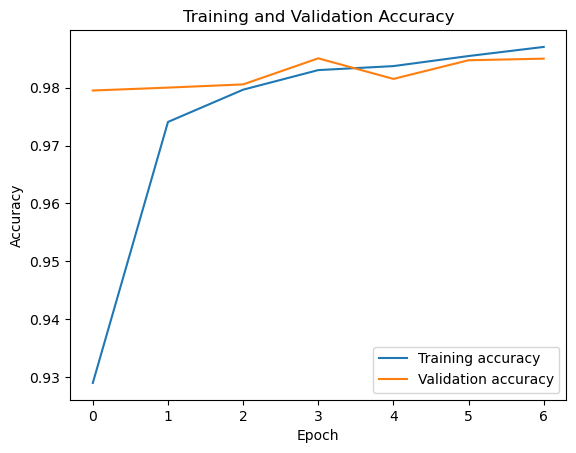

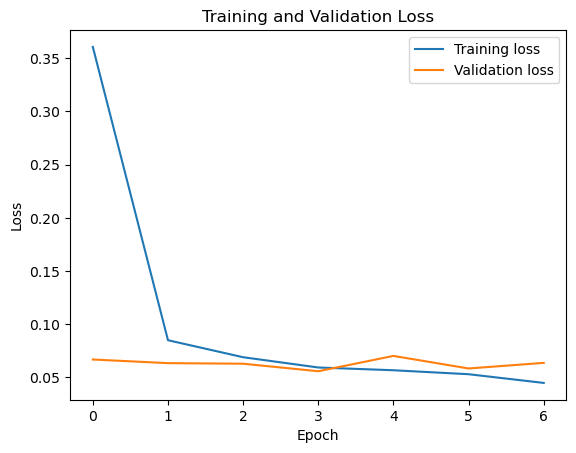

In [129]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(model_history.history['accuracy'], label='Training accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(model_history.history['loss'], label='Training loss')
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


### Wrong Classification Examples

313/313 [==============================] - 1s 2ms/step


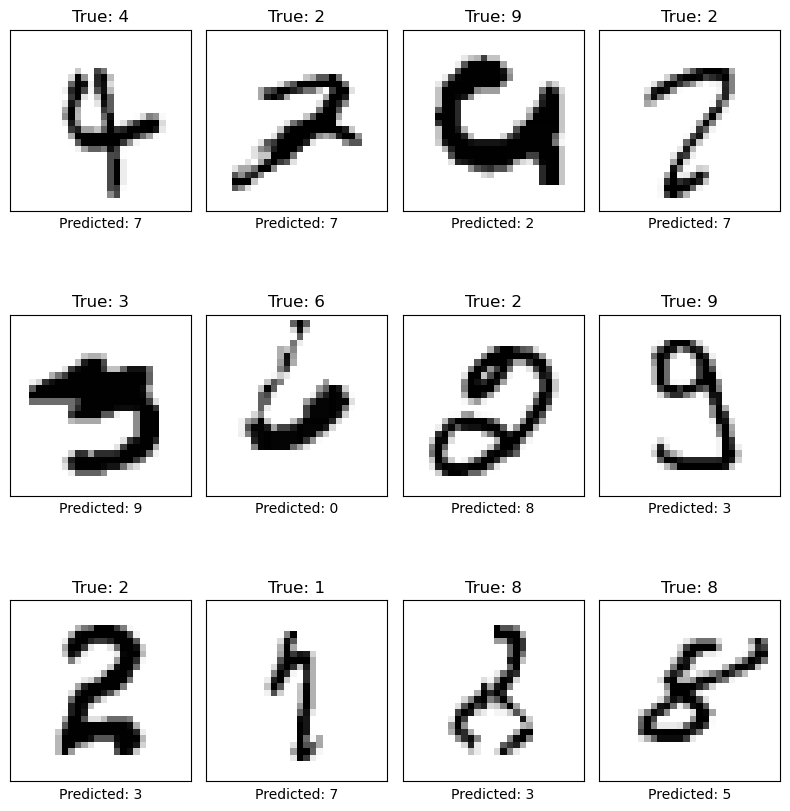

In [238]:
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

wrong_indices = np.nonzero(y_pred_classes != y_test)[0]
sample_indices = np.random.choice(wrong_indices, 12, replace=False)

plot_images(images=X_test[sample_indices], y_true=y_test[sample_indices], y_pred=y_pred_classes[sample_indices])

### Plot Confusion Matrix

- **Most Confused Digits**: There are some off-diagonal values where the model gets confused:
  - The number `5` is sometimes confused with `3` and `8`.
  - The number `3` is sometimes confused with `5` and `8`.
  - The number `4` is sometimes confused with `9`.

- **Least Confused Digits**: The digits `1`, `2`, and `7` have very few confusions compared to other digits.

- **Potential Misclassification Patterns**: Some patterns of misclassification suggest that certain features of `3`, `5`, and `8` are similar, leading to confusion. Similarly, features of `4` and `9` might be causing confusion between these digits. 

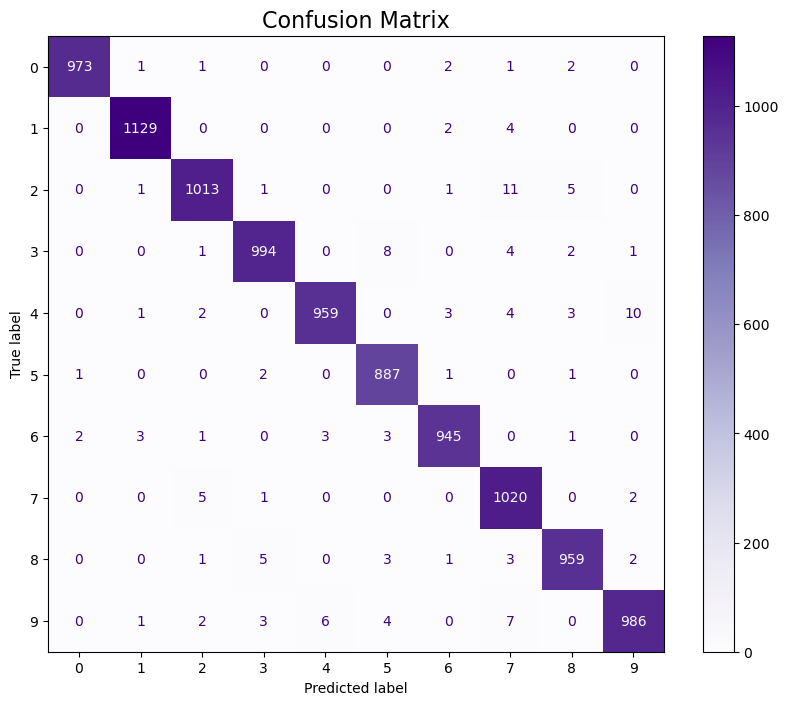

In [231]:
# Confusion Matrix

# Get unique labels
labels = np.unique(y_test)

# Create Confusion Matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Create a new figure with the desired size
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the confusion matrix and specify the colormap
plot = disp.plot(cmap='Purples', ax=ax)

# Set the title
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.show()


### Test model with random sample

1/1 [==============================] - 0s 11ms/step
Predicted Class: [2 4 5 0 9 0 2 3 1 4 2 9 1 2 6 6]


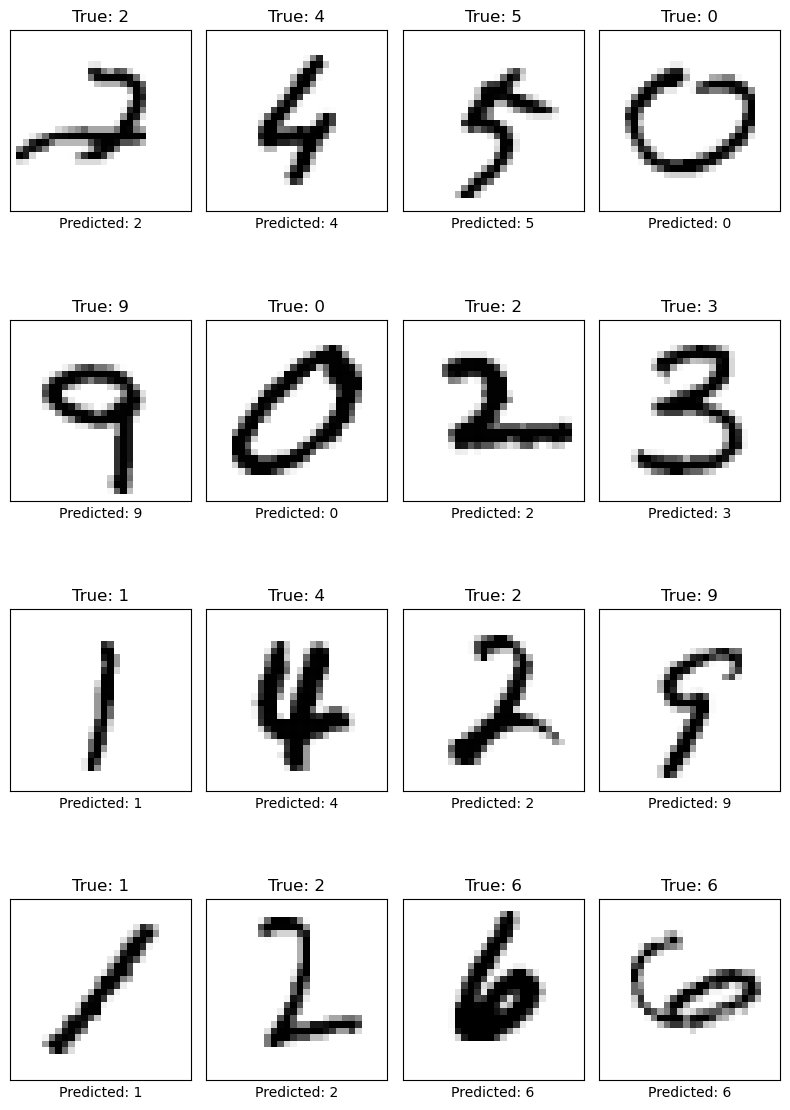

In [230]:
# Get random samples
random_indices = get_random_sample_indices(array=X_test, sample_count=16)

predictions = cnn_model.predict(X_test[random_indices])

# Decode the prediction
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted Class: {predicted_class}')

plot_images(X_test[random_indices], y_true=y_test[random_indices], y_pred=predicted_class)